# Distance traveled analysis
## Mean movement for each fly in the group

Number of groups
cScH: 23  Cs5DIZ: 20  LDA: 24  OCT: 19 LDA_OCT: 11
Number of samples
cScH: 276  Cs5DIZ: 240  LDA: 288  OCT: 228 LDA_OCT: 132 

F_onewayResult(statistic=22.185914290213475, pvalue=1.1407103621751864e-17)
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj    lower    upper   reject
-------------------------------------------------------------------
        CsCh      Cs_5DIZ -47.1172    0.0   -74.031 -20.2034   True
        CsCh     LDA_5DIZ  13.1482 0.6288  -12.5379  38.8344  False
        CsCh LDA_OCT_5DIZ -73.8424    0.0 -106.1124 -41.5724   True
        CsCh     OCT_5DIZ -44.2219 0.0001  -71.5119 -16.9319   True
     Cs_5DIZ     LDA_5DIZ  60.2654    0.0   33.6137  86.9171   True
     Cs_5DIZ LDA_OCT_5DIZ -26.7252 0.1768   -59.769   6.3185  False
     Cs_5DIZ     OCT_5DIZ   2.8953 0.9986  -25.3054   31.096  False
    LDA_5DIZ LDA_OCT_5DIZ -86.9907    0.0 -119.0424 -54.9389   True
    LDA_5DIZ     OCT_5DIZ -57.37

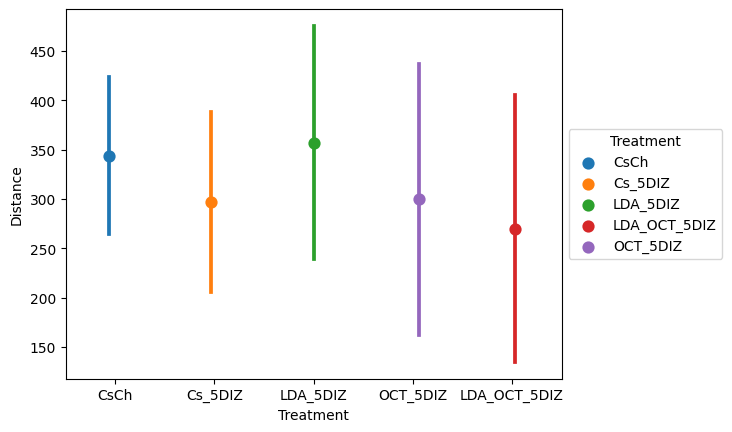

In [7]:
import os
import toml
import scipy.stats

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from src import settings
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, "main.toml")
with open(CONFIG_PATH, "r") as file:
    config = toml.load(file)
    
TIME_WINDOW=config["TIME_WINDOW"]

INPUT_PATH = os.path.join(settings.RESULTS_DIR, "distances_traveled")

all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key in config["TREATMENTS"]}

treatment_dataframes = []
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_files_from_folder(treatment_path)
    group_dataframes = []
    for group_name, df_path in all_groups.items():
        df = pd.read_csv(df_path, index_col=0)  
        df['Snapshot'] = (df.index / config["FPS"] / TIME_WINDOW).astype(int) + 1
        df['Group'] = group_name.replace(".csv","")

        group_dataframes.append(df)

    df = pd.concat(group_dataframes)
    df.set_index('Snapshot', inplace=True)
    df.set_index('Group', append=True, inplace=True)

    df['Treatment'] = treatment_name
    df.set_index('Treatment', append=True, inplace=True)
    df = df.reorder_levels(['Treatment', 'Group', 'Snapshot'])
  
    treatment_dataframes.append(df)
    
combined_data = pd.concat(treatment_dataframes)

sum_w = combined_data.groupby(['Treatment', 'Group']).sum()
sum_w = sum_w.stack().reset_index().rename(columns={'level_2': 'Fly', 0: 'Distance'})
sum_w['Distance'] = sum_w['Distance']/24

order = ['CsCh', 'Cs_5DIZ', 'LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ'] 
sns.pointplot(data=sum_w, x='Treatment', y='Distance', hue='Treatment', errorbar="sd", dodge=True, order=order)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Treatment")

sum_CsCh = sum_w[sum_w['Treatment']=='CsCh']['Distance']
sum_Cs_5DIZ = sum_w[sum_w['Treatment']=='Cs_5DIZ']['Distance']
sum_LDA_5DIZ = sum_w[sum_w['Treatment']=='LDA_5DIZ']['Distance']
sum_OCT_5DIZ = sum_w[sum_w['Treatment']=='OCT_5DIZ']['Distance']
sum_LDA_OCT_5DIZ = sum_w[sum_w['Treatment']=='LDA_OCT_5DIZ']['Distance']

anova_result = scipy.stats.f_oneway(sum_CsCh, sum_Cs_5DIZ, sum_LDA_5DIZ, sum_OCT_5DIZ, sum_LDA_OCT_5DIZ)

print('Number of groups')
print(f'cScH: {int(len(sum_CsCh)/12)}  Cs5DIZ: {int(len(sum_Cs_5DIZ)/12)}  LDA: {int(len(sum_LDA_5DIZ)/12)}  OCT: {int(len(sum_OCT_5DIZ)/12)} LDA_OCT: {int(len(sum_LDA_OCT_5DIZ)/12)}')
print('Number of samples')
print(f'cScH: {len(sum_CsCh)}  Cs5DIZ: {len(sum_Cs_5DIZ)}  LDA: {len(sum_LDA_5DIZ)}  OCT: {len(sum_OCT_5DIZ)} LDA_OCT: {len(sum_LDA_OCT_5DIZ)} \n')

print(f'{anova_result}')

all_data = np.concatenate([sum_CsCh, sum_Cs_5DIZ, sum_LDA_5DIZ, sum_OCT_5DIZ, sum_LDA_OCT_5DIZ])
group_labels = ['CsCh'] * len(sum_CsCh) + ['Cs_5DIZ'] * len(sum_Cs_5DIZ) + ['LDA_5DIZ'] * len(sum_LDA_5DIZ) + ['OCT_5DIZ'] * len(sum_OCT_5DIZ) + ['LDA_OCT_5DIZ'] * len(sum_LDA_OCT_5DIZ)
tukey_results = pairwise_tukeyhsd(all_data, group_labels)

print(tukey_results)